<a href="https://colab.research.google.com/github/Location-Artistry/GEO-DEV-NOTEBOOKS/blob/main/DASHBOARD_UPDATE_WATER_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **UPDATE AGOL WATER DASHBOARD SCRIPTS**
## Cloned from: WATER-SAMP-SETUP-2021
Updated agol_class 6-29-2021   
Added updateLayerFromTable() function   
Updated agol-class Notebook 6-29-2021 - Pushed to LocationArtistry Github

## IMPORT DEPENDENCIES
**Updated 6-15-2021**   
Must RESTART Runtime and re-run after first execution



In [ ]:
# geoPandas libraries
# Not needed in this project
# !apt install gdal-bin python-gdal python3-gdal
# !apt install python3-rtree
# !pip install pygeos 
# !pip install git+git://github.com/geopandas/geopandas.git
# import geopandas as gpd

# ArcGIS Python API libraries 
!pip install arcgis
from arcgis.gis import GIS, Item
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap
from arcgis.features import FeatureLayer

import datetime as dt
import getpass
import pandas as pd
import time

## agol CLASS DEFINITION

In [2]:
# Create new class from ArcGIS Python API functions
class agol:
  # -init- function, get user credentials to access GIS object, new Class = agol
  def __init__(self):
    userID = input(f'ArcGIS Online USER ID: ')
    pwd = getpass.getpass('PASSWORD: ')
    try:  
      self.gis = GIS("https://www.arcgis.com", userID, pwd)
      display(f'SUCCESS - CONNECTED TO: {self.gis.users.me.username} ACCOUNT as <gis>')
      display(self.gis)
    except:
        display(f'ERROR DID NOT CONNECT TO: {userID}')
# get list of all owner AGOL items, print list with title, id, type, and categories
  def getContent(self):
    try:
      my_content = self.gis.content.search(query="owner:" + self.gis.users.me.username, item_type="", max_items=500)
      for x in my_content:
        strMod = str(x.modified)
        stampInt = int(strMod[0:10])
        print(f'{x.title} - {x.id} - {x.type} - {x.categories} - {dt.datetime.fromtimestamp(stampInt)}')
      return my_content
    except:
      print('ERROR could not get user content')
# Clone item using id of item passed to function
  def cloneItem(self, gis2, cloneID):    
    try:
      itemToClone = self.gis.content.get(cloneID)
      print('Cloning:' + itemToClone.title + ' - ' + itemToClone.id + ' -',itemToClone.type)
      clonedItem = gis2.gis.content.clone_items(items=[itemToClone])
      print(f'Cloned Item: {clonedItem[0]}')
      #return clonedItem
    except:
      print('ERROR Could Not Clone')
# updated searchByKeywords, returns LIST of items 8-14-2020
  def search(self, keyWords, maxItems, iType = ''):
    try:
        search = self.gis.content.search(query=f'{keyWords}', item_type=iType, max_items=maxItems)
        for x, z in enumerate(search):
          strMod = str(z.modified)
          stampInt = int(strMod[0:10])
          print(f'{x} - {z.title} - {z.id} - {z.type} - {z.categories} - {dt.datetime.fromtimestamp(stampInt)}')
        return search
    except:
        print('ERROR Search not Successful')
# find item by keywords and display visual card
  def searchViz(self, keyWords):
    try:
        search = self.gis.content.search(query=f'{keyWords}', item_type='', max_items=50)
        for z in search:
            print(f'title: {z.title} - itemID: {z.id} - type: {z.type}')
            display(z)
    except:
        print('ERROR Search not Successful')
# return all keys and values for item when passed itemID string
  def itemInfo(self, id):
    try:
      getInfo = self.gis.content.get(id)
      for key, value in getInfo.items():
        display(f'{key}: {value}')
    except:
      display('ERROR GET Keys/Values not Successful')    
# takes itemID and gets and returns layerObject if exist, otherwise 'no layers found'
  def getLayers(self, id):
    try:
      feature = self.gis.content.get(id)
      featLay = feature.layers
      for z, x in enumerate(featLay):
        display(f'Layer {z}: {x}')
        return featLay
    except:
        display('no layers found')
# supply feature layer itemID, and the layer number to display table head
# Needs work, displays Feature Layer, not related table 
  def getLayerTable(self, id, layNum):
    try:
      layOut = self.getLayers(id)
      layQuery = layOut[layNum].query()
      display(layQuery.sdf.head())
    except:
      print('ERROR no Tables Found')
# delete item by itemID
  def deleteItem(self, id):
    delItem = self.gis.content.get(id)
    display(delItem)
    delQuest = input(f'Are you sure you want to delete: {delItem.title}')
    try:
      if delQuest.upper() == 'YES':
        display(f'DELETING: {delItem.title}')
        delItem.delete()
      else:
        display(f'NOT DELETING: {delItem.title}')
    except:
        display(f'ERROR failed to DELETE: {delItem.title}')
# create new agolItem class
  def getItem(self, id):
    try:
      item = agolItem(self, id)
      return item
    except:
        display(f'ERROR failed to GET item ID: {id}')
# Function to update attributes in a Feature Layer based on related table values
  def updateLayerFromTable(self, ref):
    # Search for Feature Layer to be updated
    keyWords = input(f'Item Search Query: ') or ''
    iType = input(f'AGOL Item Type: ') or ''
    search = self.search(keyWords, 10,iType)
    ind = int(input(f'Search Item Index: ')) or 0
    # create item as target for update operation
    item = self.getItem(search[ind].id)
    # agol defined functions to get table and layer from the Feature Service
    table = item.getTable()
    layer = item.getLayer()
    # Create FeatureSets from the target layers and tables
    tableFeat = table.table.query()
    layerFeat = layer.layer.query()
    # find the primary key to match layer and table
    for i, field in enumerate(layerFeat.fields):
      print(f'{i} - {field["name"]}')
    ind = int(input(f'PRIMARY MATCH KEY INDEX: ')) or 0
    pKey = layerFeat.fields[ind]["name"]
    # find the target field name
    for i, field in enumerate(layerFeat.fields):
      print(f'{i} - {field["name"]}')
    ind = int(input(f'Layer Target Field Index: ')) or 0
    layAtt = layerFeat.fields[ind]["name"]
    # set target attribute to zero
    for lFeat in layerFeat:
      lFeat.set_value(layAtt, 0)
    edits = layer.layer.edit_features(updates=layerFeat)
    # find the table source field name
    for i, field in enumerate(tableFeat.fields):
      print(f'{i} - {field["name"]}')
    ind = int(input(f'Table Source Field Index: ')) or 0
    tabAtt = tableFeat.fields[ind]["name"]
    # final portion of function
    for tFeat in tableFeat:
    # test for null features
      if (tFeat.attributes['WATER_TEMP']):
        # loop through all layer features to find match with pKey
        for lFeat in layerFeat:
          if tFeat.attributes[pKey] == lFeat.attributes[pKey]:
            print(f'{tFeat.attributes[pKey]} matches {lFeat.attributes[pKey]} value {tFeat.attributes[tabAtt]}')
            for x,val in enumerate(ref, start=1):
              if tFeat.attributes[tabAtt] < val:
                print(f'found value {x}')
                lFeat.set_value(layAtt, x)
                break
    # Now update target layer with updated FeatureSet using edit_features()            
    edits = layer.layer.edit_features(updates=layerFeat)
    # Count edited features, currently counting all features
    for i, edit in enumerate(edits['updateResults'],start=1):
      pass
    print(f'updated {layer.layer.properties.name} with {i} edits')

class agolItem:
# -init- function - create new agol item from agol CLASS and item.id
  def __init__(self,agol,id):
    try:  
      self.item =  agol.gis.content.get(id)
      display(self.item)
    except:
        display(f'ERROR failed to GET item ID: {id}')
  def info(self):
    try:
      keys, infoList = ['id', 'description', 'extent', 'spatialReference', 'url', 'owner', 'layers', 'tables'], []
      for i, z in enumerate(keys):
        infoList.append(self.item[z])
        display(f'{i} - {z} - {self.item[z]}')
      return infoList
    except:
      display(f'FAILED to get infoList for {self.item.title}')
# -init function - get layer from item create new agolLayer Class
  def getLayer(self):
    try:
      for i, lyr in enumerate(self.item.layers):
        display(f'{i} - {lyr.properties.name}')
      time.sleep(1)
      ind = int(input('Select index of Layer: '))
      url = self.item.url
      layer = agolLayer(url, ind)
      return layer
    except:
      display(f'Could not Get Layers for: {self.ags.url}')
  def getTable(self):
    try:
      for i, tab in enumerate(self.item.tables):
        display(f'{i} - {tab.properties.name}')
      time.sleep(1)
      # Quick fix to get proper id index for table instead of related layer
      ind = int(input('Select index of Table: '))  + 1
      url = self.item.url
      table = agolTable(url, ind)
      return table
    except:
      display(f'Could not Get Tables for: {self.ags.url}')
             
class agolLayer:
# -init function - get layer from item create new agolLayer Class 
  def __init__(self, url, ind):
    try:  
      layUrl = (f'{url}/{ind}')
      self.layer = FeatureLayer(layUrl)
    except:
        display(f'ERROR failed to GET Layer: {ind}')
  def layerQuery(self):
    try:
      baseURL = self.layer.url
      SQL = input(f'SQL query(ENTER for ALL): ') or '1=1'
      fields = input(f'Fields(ENTER for ALL)? ') or '*'
      url = (f'{baseURL}/query?f=geojson&where={SQL}&outFields={fields}')
      gdf = gpd.read_file(url)
      return gdf
    except:
      display(f'Query unsuccessful for: {self.item.title}')

class agolTable:
# -init function - get layer from item create new agolLayer Class 
  def __init__(self, url, ind):
    try:  
      tabUrl = (f'{url}/{ind}')
      self.table = FeatureLayer(tabUrl)
    except:
        display(f'ERROR failed to GET Table: {ind}')
  def tableQuery(self):
    try:
      baseURL = self.table.url
      SQL = input(f'SQL query(ENTER for ALL): ') or '1=1'
      fields = input(f'Fields(ENTER for ALL)? ') or '*'
      url = (f'{baseURL}/query?f=geojson&where={SQL}&outFields={fields}')
      gdf = gpd.read_file(url)
      return gdf
    except:
      display(f'Query unsuccessful for: {self.item.title}')

## Final Dashboard Update Workflow
### 6-29-2021 method added into agol() class

In [3]:
# First login to creat agol() class item
gis = agol()

ArcGIS Online USER ID: ekerney_nhbptribe
PASSWORD: ··········


'SUCCESS - CONNECTED TO: ekerney_nhbptribe ACCOUNT as <gis>'

GIS @ https://nhbptribe.maps.arcgis.com version:9.2

Item Search Query: water sampling 2021
AGOL Item Type: 
0 - WATER_SAMPLING_2021 - 66523a79c3de4074b99b0d84e985bb71 - Feature Service - [] - 2021-06-16 16:34:46
1 - SAMPLE_DESIGN_2021 - c94a036ea6bf42e6a0aa7a0fede83e5a - Feature Service - [] - 2021-06-16 15:47:35
2 - Grand River Water Sampling 2021 - f0f2ddb89d204ff18fcbbf106c1b6bb5 - Dashboard - ['/Categories/DASHBOARDS'] - 2021-04-23 01:45:33
Search Item Index: 0


<Item title:"WATER_SAMPLING_2021" type:Feature Layer Collection owner:ekerney_nhbptribe>
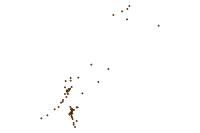

'0 - WATER_DATA_2021'

Select index of Table: 0


'0 - WATER_STATIONS_2021'

Select index of Layer: 0
0 - OBJECTID
1 - DATE_TIME
2 - SITE_ID
3 - STAFF
4 - SAMP_EQUIP
5 - AIR_TEMP
6 - CUR_PRECIP
7 - PREV_48_PRECIP
8 - WIND_SPEED
9 - WEATHER_NOTES
10 - WATER_TEMP
11 - DO_mgl
12 - SPEC_COND_uS_cm
13 - TURB_NTU
14 - pH
15 - QC
16 - DEPTH_FT
17 - NOTES
18 - LOCATION
19 - LAB_SAMP_QUES
20 - Ecoli_100ml_
21 - TOT_PHOS_
22 - TOT_NITRO_
23 - LAKE_SAMP_QUES_
24 - SECCH_DEP_FT_
25 - CHLOROPHYLLa_ug_L_
26 - STAT_SAMP_QUES_
27 - ECOLI_STATUS_
28 - DO_STATUS_
29 - TEMP_STATUS_
30 - TURB_STATUS_
31 - GlobalID
PRIMARY MATCH KEY INDEX: 2
0 - OBJECTID
1 - DATE_TIME
2 - SITE_ID
3 - STAFF
4 - SAMP_EQUIP
5 - AIR_TEMP
6 - CUR_PRECIP
7 - PREV_48_PRECIP
8 - WIND_SPEED
9 - WEATHER_NOTES
10 - WATER_TEMP
11 - DO_mgl
12 - SPEC_COND_uS_cm
13 - TURB_NTU
14 - pH
15 - QC
16 - DEPTH_FT
17 - NOTES
18 - LOCATION
19 - LAB_SAMP_QUES
20 - Ecoli_100ml_
21 - TOT_PHOS_
22 - TOT_NITRO_
23 - LAKE_SAMP_QUES_
24 - SECCH_DEP_FT_
25 - CHLOROPHYLLa_ug_L_
26 - STAT_SAMP_QUES_
27 - ECOLI_STATUS_
28 - DO_STATUS

In [5]:
# Use updateLayerFromTable() method to update sampling stations
# Single argument is list of reference values to classify value categories
# Search Query 'water sampling 2021' - Table Index: 0 - Layer Index: 0
# Match Key: 'SITE_ID(2)' - Layer Target: "DO_STATUS_(28)" - Source Field: 'DO_mgl(11)'
gis.updateLayerFromTable([5,6,7,100])